In [42]:
import keras.backend as K
from keras.layers import Input, Add, Dense, Activation, Flatten, Dropout, Conv3D, MaxPooling3D, ZeroPadding3D, AveragePooling3D, TimeDistributed
from keras.models import Model
from keras.regularizers import l1, l2
from keras.optimizers import Adam, SGD
from keras.constraints import max_norm
from keras.layers.noise import GaussianNoise
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix, f1_score
import operator
import matplotlib.pyplot as plt
import config
import importlib
import os
import copy
import pandas as pd
import re
import numpy as np
from scipy.misc import imsave
import tensorflow as tf
%matplotlib inline

from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

nb_classes = C.nb_classes

X_train = np.expand_dims(x_train,axis=3)
X_train = np.expand_dims(X_train,axis=4)
X_test = np.expand_dims(x_test,axis=3)
X_test = np.expand_dims(X_test,axis=4)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [110]:
importlib.reload(config)

<module 'config' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\config.py'>

In [111]:
C = config.Config()
dims = C.dims
voi_img = Input(shape=(dims[0], dims[1], dims[2], C.nb_channels))
x = voi_img
#x = GaussianNoise(1)(x)
#x = ZeroPadding3D(padding=(3,3,2))(voi_img)
#x = Conv3D(filters=128, kernel_size=(3,3,2), activation='relu')(x)
x = Conv3D(filters=32, kernel_size=(3,3,1), activation='relu', kernel_constraint=max_norm(4.))(x)
x = Dropout(0.5)(x)
x = MaxPooling3D((2, 2, 1))(x)
x = Conv3D(filters=64, kernel_size=(3,3,2), activation='relu', kernel_constraint=max_norm(4.))(x)
x = Dropout(0.5)(x)
#x = Conv3D(filters=128, kernel_size=(2,2,2), activation='relu')(x)
x = MaxPooling3D((2, 2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_constraint=max_norm(4.))(x)#, kernel_initializer='normal', kernel_regularizer=l1(.01), kernel_constraint=max_norm(3.))(x)
x = Dropout(0.5)(x)
pred_class = Dense(C.nb_classes, activation='softmax')(x)#Dense(C.nb_classes, activation='softmax')(x)

In [112]:
optim = Adam(lr=0.01)#, decay=0.001)
early_stopping = EarlyStopping(min_delta=0.001, patience=10)

model = Model(voi_img, pred_class)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 24, 24, 12, 1)     0         
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 22, 22, 12, 32)    320       
_________________________________________________________________
dropout_22 (Dropout)         (None, 22, 22, 12, 32)    0         
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 11, 11, 12, 32)    0         
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 9, 9, 11, 64)      36928     
_________________________________________________________________
dropout_23 (Dropout)         (None, 9, 9, 11, 64)      0         
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 4, 4, 5, 64)       0         
__________

model2 = Model(voi_img, intermed)

for l in range(2,len(model2.layers)):
    model2.layers[l].set_weights(model.layers[l].get_weights())

X_train = []
Y_train = []

for _ in range(10):
    X_train.append(np.ones(dims + [C.nb_channels]))
    Y_train.append([1,0])
for _ in range(10):
    X_train.append(np.ones(dims + [C.nb_channels]))
    X_train[-1][5:15,5:15,5:7,0] = 2
    Y_train.append([0,1])
    
X_train = np.array(X_train) # X[:total_size//2]
#X_val = np.array(X_test)
Y_train = np.array(Y_train) # Y[:total_size//2]
#Y_val = np.array(Y_test)

In [113]:
classes = ['cyst', 'hcc', 'fnh', 'hemangioma']

In [114]:
orig_data_dict = {}
num_samples = {}
    
for class_name in classes:#os.listdir(C.orig_dir):
    x = np.empty((10000, dims[0], dims[1], dims[2], C.nb_channels))
    z = []
    
    for index, img_fn in enumerate(os.listdir(C.orig_dir+class_name)):
        try:
            x[index] = np.load(C.orig_dir+class_name+"\\"+img_fn)
        except:
            raise ValueError(C.orig_dir+class_name+"\\"+img_fn + " not found")
        z.append(img_fn)
    
    x.resize((index, dims[0], dims[1], dims[2], C.nb_channels)) #shrink first dimension to fit
    orig_data_dict[class_name] = [x,np.array(z)]
    num_samples[class_name] = index

In [115]:
num_samples

{'cyst': 72, 'fnh': 58, 'hcc': 50, 'hemangioma': 53}

In [116]:
train_ids = {} #filenames of training set originals
test_ids = {} #filenames of test set
X_test = []
Y_test = []
Z_test = []
X_train_orig = []
Y_train_orig = []
Z_train_orig = []
cls_mapping = []

train_frac = {"cyst": 0.75, "fnh": 0.75, "hcc": 0.75, "hemangioma": 0.75}
train_samples = {}

for cls_num, cls in enumerate(orig_data_dict):
    train_samples[cls] = round(num_samples[cls]*train_frac[cls])
    
    order = np.random.permutation(list(range(num_samples[cls])))
    train_ids[cls] = list(orig_data_dict[cls][1][order[:train_samples[cls]]])
    test_ids[cls] = list(orig_data_dict[cls][1][order[train_samples[cls]:]])
    
    X_test = X_test + list(orig_data_dict[cls][0][order[train_samples[cls]:]])
    Y_test = Y_test + [[0] * cls_num + [1] + [0] * (C.nb_classes - cls_num - 1)] * \
                        (num_samples[cls] - train_samples[cls])
    Z_test = Z_test + list(orig_data_dict[cls][1][order[train_samples[cls]:]])
    cls_mapping.append(cls)
    
    X_train_orig = X_train_orig + list(orig_data_dict[cls][0][order[:train_samples[cls]]])
    Y_train_orig = Y_train_orig + [[0] * cls_num + [1] + [0] * (C.nb_classes - cls_num - 1)] * \
                        (train_samples[cls])
    Z_train_orig = Z_train_orig + list(orig_data_dict[cls][1][order[:train_samples[cls]]])
    
    print("%s has %d samples for training (%d after augmentation) and %d for testing" %
          (cls, train_samples[cls], train_samples[cls] * C.aug_factor[cls], num_samples[cls] - train_samples[cls]))

hcc has 38 samples for training (3800 after augmentation) and 12 for testing
cyst has 54 samples for training (5400 after augmentation) and 18 for testing
hemangioma has 40 samples for training (4000 after augmentation) and 13 for testing
fnh has 44 samples for training (4400 after augmentation) and 14 for testing


In [117]:
train_samples

{'cyst': 54, 'fnh': 44, 'hcc': 38, 'hemangioma': 40}

In [118]:
aug_data_dict = {}

for class_name in classes:#os.listdir(C.aug_dir):
    x_train = np.empty((10000, dims[0], dims[1], dims[2], C.nb_channels))
    x_val = np.empty((10000, dims[0], dims[1], dims[2], C.nb_channels))
    z = []
    
    train_cnt = 0
    val_cnt = 0
    for img_fn in os.listdir(C.aug_dir+class_name):
            
        if "_".join(img_fn.split("_")[:2])+".npy" in train_ids[class_name]:
            try:
                x_train[train_cnt] = np.load(C.aug_dir+class_name+"\\"+img_fn)
            except:
                raise ValueError(C.aug_dir+class_name+"\\"+img_fn + " cannot be loaded")
            train_cnt += 1
            z.append(img_fn)
            
        else:
            try:
                x_val[val_cnt] = np.load(C.aug_dir+class_name+"\\"+img_fn)
            except:
                raise ValueError(C.aug_dir+class_name+"\\"+img_fn + " cannot be loaded")
            val_cnt += 1
    
    x_train.resize((train_cnt, dims[0], dims[1], dims[2], C.nb_channels)) #shrink first dimension to fit
    x_val.resize((val_cnt, dims[0], dims[1], dims[2], C.nb_channels)) #shrink first dimension to fit
    aug_data_dict[class_name] = {'train': [x_train,np.array(z)], 'val': x_val}

In [119]:
X_train = []
Y_train = []
Z_train = []
X_val = []
Y_val = []
Z_val = []

for cls_num, cls in enumerate(aug_data_dict):
    X_train = X_train + list(aug_data_dict[cls]['train'][0])
    Y_train = Y_train + [[0] * cls_num + [1] + [0] * (C.nb_classes - cls_num - 1)] * len(aug_data_dict[cls]['train'][0])
    Z_train = Z_train + list(aug_data_dict[cls]['train'][1])
    
    X_val = X_val + list(aug_data_dict[cls]['val'])
    Y_val = Y_val + [[0] * cls_num + [1] + [0] * (C.nb_classes - cls_num - 1)] * len(aug_data_dict[cls]['val'])

Z_cyst = data_dict["cyst"][1]

Y_[-4]

Z_cyst[-4]

X_cyst = data_dict["cyst"][0]
X_cyst = np.array(X_cyst) # X[:total_size//2]
X_cyst /= 255

X_hcc = data_dict["hcc"][0]
X_hcc = np.array(X_hcc) # X[:total_size//2]
X_hcc /= 255

In [120]:
X_train = np.array(X_train) / 255 # X[:total_size//2]
X_val = np.array(X_val) / 255
X_test = np.array(X_test) / 255
Y_train = np.array(Y_train)
Y_val = np.array(Y_val)
Z_train = np.array(Z_train)
Z_test = np.array(Z_test)

X_train_orig = np.array(X_train_orig) / 255
Y_train_orig = np.array(Y_train_orig)
Z_train_orig = np.array(Z_train_orig)

In [28]:
#X = np.array([z for z in x])
#Y = np.array(y)
#Y = np.array([[0,1] if y[x] == 1 else [1,0] for x in range(len(y))])
#Y = K.constant(y, dtype=tf.int32)
#Y = K.one_hot(Y, C.nb_classes)

#total_size = X.shape[0]

#order = np.random.permutation(list(range(total_size)))
#X = X[order]
#Y = Y[order]

In [121]:
hist = model.fit(X_train, Y_train, batch_size=32, epochs=200, validation_data=(X_val, Y_val)) #callbacks=[early_stopping]

Train on 8800 samples, validate on 3050 samples
Epoch 1/200
8800/8800 [==============================] - 7s - loss: 1.1320 - acc: 0.4725 - val_loss: 1.1589 - val_acc: 0.4098
Epoch 2/200
8800/8800 [==============================] - 6s - loss: 0.7803 - acc: 0.6589 - val_loss: 1.0673 - val_acc: 0.5318
Epoch 3/200
8800/8800 [==============================] - 7s - loss: 0.5960 - acc: 0.7452 - val_loss: 1.0127 - val_acc: 0.5620
Epoch 4/200
8800/8800 [==============================] - 7s - loss: 0.4883 - acc: 0.7964 - val_loss: 1.0015 - val_acc: 0.5416
Epoch 5/200
8800/8800 [==============================] - 6s - loss: 0.3952 - acc: 0.8391 - val_loss: 0.9867 - val_acc: 0.5511
Epoch 6/200
8800/8800 [==============================] - 6s - loss: 0.3480 - acc: 0.8595 - val_loss: 0.9942 - val_acc: 0.5370
Epoch 7/200
8800/8800 [==============================] - 6s - loss: 0.3002 - acc: 0.8772 - val_loss: 1.0046 - val_acc: 0.5475
Epoch 8/200
8800/8800 [==============================] - 6s - loss: 0.

KeyboardInterrupt: 

def train_generator(X, Y):
    while True:
        for i in range(len(X)):
            yield np.expand_dims(X[i], axis=0), np.expand_dims(Y[i], axis=0)

num_epochs = 10
epoch_length = 100
best_loss = np.Inf
losses = np.zeros(epoch_length)
acc = np.zeros(epoch_length)

data_gen_train = train_generator(X_train, Y_train)
for epoch_num in range(num_epochs):
    print('Epoch {}/{}'.format(epoch_num + 1, num_epochs))
    iter_num = 0
    
    while True:
        X, Y = next(data_gen_train)
        losses[iter_num], acc[iter_num] = model.train_on_batch(X, Y)

        iter_num += 1
        if iter_num == epoch_length:
            curr_loss = np.mean(losses)
            curr_acc = np.mean(acc)
            print("Mean Loss:", curr_loss, "// Mean Accuracy:", curr_acc)

            if curr_loss < best_loss:
                print('Total loss decreased from {} to {}, saving weights'.format(best_loss,curr_loss))
                best_loss = curr_loss
                model.save_weights(C.model_path)
            break

In [122]:
# TODO: modify to handle padding going out of bounds
def plot_with_bbox(fn, wrong_class, pad=15, draw_bbox=False, save_dir=None):
    voi_df = pd.read_csv('vois.csv')
    z = re.search(r'^(.*)_(\d*)\.', fn)
    
    img_fn = z.group(1) + ".npy"
    df = voi_df[voi_df["Filename"] == img_fn].iloc[int(z.group(2))]
    
    img = np.load("full_imgs\\"+img_fn)
    #if
    slice_num = (df['z1']+df['z2'])//2
    img_slice = img[:,:, slice_num, 0]
    img_slice = np.stack([img_slice, copy.deepcopy(img_slice), copy.deepcopy(img_slice)], axis=2)
    
    if draw_bbox:
        img_slice[df['x1']:df['x2'], df['y2'], 0] = 1
        img_slice[df['x1']:df['x2'], df['y2'], 1:] = 0
        
        img_slice[df['x1']:df['x2'], df['y1'], 0] = 1
        img_slice[df['x1']:df['x2'], df['y1'], 1:] = 0
        
        img_slice[df['x1'], df['y1']:df['y2'], 0] = 1
        img_slice[df['x1'], df['y1']:df['y2'], 1:] = 0
        
        img_slice[df['x2'], df['y1']:df['y2'], 0] = 1
        img_slice[df['x2'], df['y1']:df['y2'], 1:] = 0
        
    if save_dir is None:
        plot_section(img_slice, df, fn, pad=pad)
    else:
        plot_section(img_slice, df, fn, save_dir=save_dir+"\\"+df['cls'], wrong_class=wrong_class, pad=pad, noshow=True)

In [123]:
def get_cropped_slice(img_slice, df, pad):
    x1 = max(df['x1']-pad, 0)
    x2 = min(df['x2']+pad, img_slice.shape[0])
    y1 = max(df['y1']-pad, 0)
    y2 = min(df['y2']+pad, img_slice.shape[1])
    
    return img_slice[x1:x2, y2:y1:-1]

In [124]:
def plot_section(img_slice, row, fn, save_dir=None, wrong_class=None, pad=15, noshow=False):
    #plt.subplot(121)
    if noshow:
        ret = np.transpose(get_cropped_slice(img_slice, row, pad), (1,0,2))
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        imsave("%s\\%s (pred %s).png" % (save_dir, fn[:-3], wrong_class), ret)
        
    else:
        ret = np.transpose(get_cropped_slice(img_slice[:,:,0], row, pad), (1,0))
        plt.imshow(ret, cmap='gray')
    #plt.subplot(122)

In [125]:
#plot_with_bbox(fn_list[2], cls_mapping[wrong_guesses[2]])
Y_pred = model.predict(X_test)
y_true = [max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_test]
y_pred = [max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred]

cm = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")

save_dir = "classified_imgs"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
#for i in range(len(Z_test)):
#    plot_with_bbox(Z_test[i], cls_mapping[np.array(y_pred)[i]], pad=30, draw_bbox=True, save_dir=save_dir)

In [56]:
Y_pred = model.predict(X_test)
y_true = [max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_test]
y_pred = [max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred]
cm = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")

In [126]:
cm

array([[ 8,  1,  2,  1],
       [ 1, 14,  1,  2],
       [ 1,  4,  7,  1],
       [ 5,  1,  2,  6]], dtype=int64)

In [44]:
Y_pred = model.predict(X_train_orig)
y_true = [max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_train_orig]
y_pred = [max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred]

cm = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")

#for i in range(len(Z_train_orig)):
#    plot_with_bbox(Z_train_orig[i], cls_mapping[np.array(y_pred)[i]], pad=30, draw_bbox=True, save_dir=save_dir)

In [365]:
fn_list = Z_test[~np.equal(y_pred, y_true)]
wrong_guesses = np.array(y_pred)[~np.equal(y_pred, y_true)]

In [409]:
Z_test[~np.equal(y_pred, y_true)]

array(['E100815762_0.npy', '12239513_0.npy', '12042703_2.npy'],
      dtype='<U16')

In [380]:
Z_test

array(['E105152534_0.npy', '13166464_0.npy', '12789019_1.npy',
       'E103514998_0.npy', 'E104430882_0.npy', '13064153_0.npy',
       '12857716_0.npy', '13064153_1.npy', 'E100718398_0.npy',
       'E101636006_0.npy', 'E105464882_0.npy', '12239513_0.npy',
       '12229245_0.npy', '12302576_2.npy', '12302576_0.npy'],
      dtype='<U16')

In [443]:
voi_df = pd.read_csv('vois.csv')
img_fn = "E100262351.npy"
img = np.load("full_imgs\\"+img_fn)
plot_section(img, voi_df[voi_df["Filename"] == img_fn].iloc[0], pad=5)

ValueError: axes don't match array

In [159]:
activ = model2.predict(X_train)
#activ = model2.predict(np.expand_dims(X_train[10],axis=0))

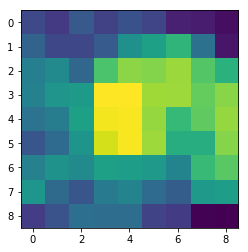

In [166]:
plt.imshow(activ[20][:,:,3,5])

In [162]:
activ[0][5,5,2,:]

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,  121.71251678,   53.23372269,    0.        ,
          0.        ,   24.43340492,    0.        ,    0.        ,
          0.        ,    0.        ,    7.88301706,    0.        ], dtype=float32)

In [316]:
import operator
#print("Ground truth:", [cls_mapping[max(enumerate(x), key=operator.itemgetter(1))[0]] for x in Y_val[::30]])
Y_ = model.predict(X_test)
print("Predictions:", [cls_mapping[max(enumerate(x), key=operator.itemgetter(1))[0]] + " (%.5f%% confidence)" % (max(x)*100) for x in Y_])

Predictions: ['hcc (95.75861% confidence)', 'hcc (99.98515% confidence)', 'hcc (56.77554% confidence)', 'hcc (97.68384% confidence)', 'hcc (96.73136% confidence)', 'hcc (99.99979% confidence)', 'hcc (99.99988% confidence)', 'hcc (99.71866% confidence)', 'cyst (63.61439% confidence)', 'cyst (51.41591% confidence)', 'hcc (99.65365% confidence)', 'hcc (52.72004% confidence)', 'hcc (57.44457% confidence)', 'cyst (99.82330% confidence)', 'cyst (83.69393% confidence)']


In [20]:
Y_[-1]

array([  2.78843247e-04,   9.99721110e-01], dtype=float32)

In [19]:
max(sum(y)/len(y), 1-sum(y)/len(y))

0.6875

In [87]:
len(X_val)

210

In [84]:
import time

In [86]:
a=time.time()
Y_ = model.predict(X_val)
print(time.time()-a)

0.20054101943969727


In [136]:
import matplotlib.pyplot as plt
%matplotlib inline

In [150]:
np.amax(X[650,:,:,:,0])

0.0

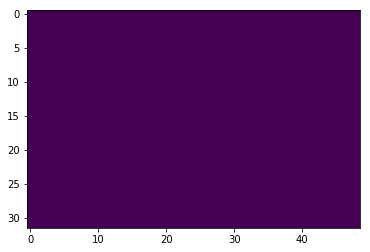

In [140]:
plt.imshow(X[0,:,:,5,0])